# Evaluation of a Convolutional Neural Network Architecture
Course project for the class _IoT Based Smart Systems_, carried out by _Riccardo Maria Pesce_ during Academic Year _2021-2022_, under the kind supervision of Professor _Maurizio Palesi_.

## Introduction

### Motivation
With the latest scientific and technological advancements that has taken place in the past few years, AI techniques have been employed in different fields, with great success. 

While Deep Learning Models are still trained on the cloud (using state-of-the-art computing machines with specialized hardware such as _GPU_ or _TPU_), it is becoming always more common to perform inference on the edge, i.e. on the devices itself, so as to reduce latency and optimize the usage of bandwith, a relevant issue for constrained devices.

### Objective
The objective of this thesis is to analyze a _CNN_ (Convolutional Neural Network) architecture performance on a constrained hardware, seeing how the mapping will affect the performance in terms of throughput and energy consumption.
In particular, these performance achievements are obtained in the following ways:

* Through reducing data movements, since communication is more expensive than computation in terms of energy nowadays. We can reduce data movements by either reducing the number of times memory is accessed, employing for instance DRAM which are nearby the _PEs_ (Processing Elements), or else we can compress data to a smaller number bits to represent it, thus making data movements cheaper. From these observations, we notice how __memory is the main bottleneck__.

* Maximizing PEs parallelism.

### Mapping
Mapping defines the order of execution of the MAC operations. The ordering can either be _temporal_ when operations are mapped serially on the same PE (i.e. the temporal order of execution), or _spatial_ when operations are mapped to multiple PE to execute in parallel.

### Introduction to Timeloop and Accelergy
In order to correctly design a DNN accelerator we need to cater for the different DNN architectures, and for each one of them we have to find an optimal mapping of these workloads onto specific hardware architectures.
This is what Timeloop and Accelergy do, and in particular:
* Timeloop generates a characterization of the energetical efficiency for each workload, through a mapper which finds the optimal way to plan operations on a specified architecture. To do so, Timeloop uses a coincise and unified representation of those core elements which are generally found in DNN accelerators.
* Accelergy, on the basis of the above created characterization, provides a pretty good estimate of energy consumption.

For a more complete introduction to Timeloop/Accelergy, please refer to [the official website](http://accelergy.mit.edu/tutorial.html).

## Simulation

### Objective

In this thesis, we want to find an efficient mapping of the _ResNet-18_ model onto particular and simple DNN architectures, and see how varying the latter paramereters influence energy consumption, performances and area occupied.

### ResNet-18

We want to give a brief overview of the _ResNet-18_ architecture. 

![ResNet-18 Architecture](./assets/resnet18.png)

The main key points, as highlighted in the above picture, are:

* ResNet-18 architecture has __4 stages__.
* Input height and width must be multiple of 32 and channel width must be equal to 3.
* The main innovation of the ResNet architecture is the introduction of the _Identity Connection_ which allows the input feature map of some layer to skip some blocks and being summed to the output feature map of the skipped layers, before passing through the activation function (which is commonly the _ReLU_). This is a very succesful strategy to improve accuracy, thanks to the fact that we limit the _vanishing gradient_ problem which often occurs in very deep neural networks.
* ResNet uses Batch Normalization to mitigate the _Covariance Shift_ problem.

For a better understanding, please check out the original paper on [ArXiv](https://arxiv.org/abs/1512.03385).

The model used for this simulation was obtained through [pytorch2timeloop-converter](https://github.com/Accelergy-Project/pytorch2timeloop-converter), which is a useful tool to get timeloop compliant architectures from Pytorch models.


### Accelerator architecture

We are going to try the ResNet-18 workload on some simple architectures, which will mainly consist of a main memory, a buffer and different processing elements (PEs).

Regarding the mapper, it can be found [here](./ResNet18/mapper/mapper.yaml). We are using eight threads in parallel, to find the best parameters to optimize _delay_ and _energy_, using a _random-pruned_ algorithms which will stop once it finds 100 configurations which perform worse than the optimal one found. 

Let's now run the simulation, remembering to __spin up Docker__ as we are using Timeloop/Accelergy through it. Also, we will use _python_ to run all the simulations for each layer automatically. We are opening a terminal window, where we are starting the container using the command `docker-compose run --rm exercises`. After this, we are putting the `ResNet18` folder inside the newly created `workspace` folder. With the below snippet of code we are generating the bash file which will be run inside the container shell to run the simulations for this first configuration and all the layers. Before running, you might need to run `chmod u+x bash_script.sh`.

In [1]:
from utils import *

generate_bash_script()

Now we want to run the different configurations, and check for each the different performance indicators, all made thanks to Python and Pandas package.
We want to first review which configurations we are considering so far:

* `base`
    * __Main Memory__ (_DRAM_), with the following attributes `width = 256`, `block-size = 32` and `word-bits = 1`
    * __Global Buffer__ (_smartbuffer SRAM_), with the following attributes `depth = 12`, `width = 16`, `block-size = 16` and `word-bits = 1`
    * __PEs__ (16)
        * __Register File__ with the following attributes `depth = 16`, `width = 8`, `block-size = 8` and `word-bits = 1`
        * __MACC__ (_intmac_) with the following attribute `data-width = 16`
* `base_bigger_buffer`, with global buffer increased to `depth = 24`, `width = 32` and `block-size = 32`
* `base_smaller_buffer`, with global buffer increased to `depth = 6`, `width = 8` and `block-size = 8`
* `base_bigger_rf`, with register file `depth = 32`, `width = 16` and `word-bits = 16`
* `base_smaller_rf`, with register file `depth = 8`, `width = 4` and `word-bits = 4`
* `base_more_pes`, number of Processing Elements increased to 32
* `base_less_pes`, number of Processing Elements increased to 8
* `base_bigger_dw`, with MACC `data-width = 16`
* `base_smaller_dw`, with MACC `data-width = 4`

And now let us iterate over each one of them, printing the different statistics.

In [2]:
# Suppress scientific notation
import pandas as pd
from pathlib import Path

pd.set_option("display.float_format", lambda x: "%.2f" % x) 

for path in sorted(Path("workspace/ResNet18/output").iterdir()):
    print("\n\n\n")
    stats, summary = generate_stats_by_arch(path)
    print(f"For configuration {path.name}")
    display(stats)
    print("\n")
    print(f"Summary stats for {path.name}")
    display(summary)
    print("\n\n\n")





For configuration conf-base


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer
1,0.01,1.00,7375872.00,3924.72,118013952.00,0.56,0.26,32.44,0.00
2,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
3,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
4,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
5,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
6,0.01,1.00,3612672.00,1903.57,57802752.00,0.56,0.26,32.11,0.00
7,0.01,1.00,7225344.00,1828.17,115605504.00,0.56,0.41,14.83,0.02
8,0.01,1.00,401408.00,104.63,6422528.00,0.56,0.40,15.33,0.00
9,0.01,1.00,7225344.00,1828.17,115605504.00,0.56,0.41,14.83,0.02
10,0.01,1.00,7225344.00,1828.17,115605504.00,0.56,0.41,14.83,0.02




Summary stats for conf-base


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer,Inferences/Second
Total,0.01,1.00,129731584.00,70577.53,2075705344.00,11.76,7.50,658.04,0.13,7.71










For configuration conf-base_bigger_buffer


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer
1,0.01,1.00,7375872.00,3925.80,118013952.00,0.56,0.26,32.44,0.00
2,0.01,1.00,7225344.00,1235.47,115605504.00,0.56,0.26,9.83,0.03
3,0.01,1.00,7225344.00,1235.47,115605504.00,0.56,0.26,9.83,0.03
4,0.01,1.00,7225344.00,1235.47,115605504.00,0.56,0.26,9.83,0.03
5,0.01,1.00,7225344.00,1235.47,115605504.00,0.56,0.26,9.83,0.03
6,0.01,1.00,3612672.00,1221.31,57802752.00,0.56,0.45,20.11,0.01
7,0.01,1.00,7225344.00,665.42,115605504.00,0.56,0.15,5.01,0.04
8,0.01,1.00,401408.00,63.81,6422528.00,0.56,0.26,9.08,0.03
9,0.01,1.00,7225344.00,665.42,115605504.00,0.56,0.15,5.01,0.04
10,0.01,1.00,7225344.00,665.42,115605504.00,0.56,0.15,5.01,0.04




Summary stats for conf-base_bigger_buffer


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer,Inferences/Second
Total,0.01,1.00,129731584.00,53549.02,2075705344.00,11.76,4.66,497.16,0.52,7.71










For configuration conf-base_bigger_dw


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer
1,0.02,1.00,7375872.00,5062.25,118013952.00,2.20,0.26,40.44,0.00
2,0.02,1.00,7225344.00,2476.41,115605504.00,2.20,0.41,18.81,0.00
3,0.02,1.00,7225344.00,2476.41,115605504.00,2.20,0.41,18.81,0.00
4,0.02,1.00,7225344.00,2476.41,115605504.00,2.20,0.41,18.81,0.00
5,0.02,1.00,7225344.00,2476.41,115605504.00,2.20,0.41,18.81,0.00
6,0.02,1.00,3612672.00,1998.31,57802752.00,2.20,0.26,32.11,0.00
7,0.02,1.00,7225344.00,2017.64,115605504.00,2.20,0.41,14.83,0.02
8,0.02,1.00,401408.00,115.15,6422528.00,2.20,0.40,15.33,0.00
9,0.02,1.00,7225344.00,2017.64,115605504.00,2.20,0.41,14.83,0.02
10,0.02,1.00,7225344.00,2017.64,115605504.00,2.20,0.41,14.83,0.02




Summary stats for conf-base_bigger_dw


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer,Inferences/Second
Total,0.02,1.00,129731584.00,74923.62,2075705344.00,46.20,7.50,666.04,0.13,7.71










For configuration conf-base_bigger_memory


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer
1,0.01,1.00,7375872.00,4868.83,118013952.00,0.56,0.26,40.44,0.00
2,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
3,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
4,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
5,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
6,0.01,1.00,3612672.00,1903.57,57802752.00,0.56,0.26,32.11,0.00
7,0.01,1.00,7225344.00,1828.17,115605504.00,0.56,0.41,14.83,0.02
8,0.01,1.00,401408.00,104.63,6422528.00,0.56,0.40,15.33,0.00
9,0.01,1.00,7225344.00,1828.17,115605504.00,0.56,0.41,14.83,0.02
10,0.01,1.00,7225344.00,1828.17,115605504.00,0.56,0.41,14.83,0.02




Summary stats for conf-base_bigger_memory


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer,Inferences/Second
Total,0.01,1.00,129731584.00,71521.64,2075705344.00,11.76,7.50,666.04,0.13,7.71










For configuration conf-base_bigger_rf


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer
1,0.01,1.00,7375872.00,3962.24,118013952.00,0.56,0.58,32.44,0.00
2,0.01,1.00,7225344.00,2345.15,115605504.00,0.56,0.92,18.81,0.00
3,0.01,1.00,7225344.00,2345.15,115605504.00,0.56,0.92,18.81,0.00
4,0.01,1.00,7225344.00,2345.15,115605504.00,0.56,0.92,18.81,0.00
5,0.01,1.00,7225344.00,2345.15,115605504.00,0.56,0.92,18.81,0.00
6,0.01,1.00,3612672.00,738.23,57802752.00,0.56,0.88,11.33,0.00
7,0.01,1.00,7225344.00,1885.99,115605504.00,0.56,0.91,14.83,0.02
8,0.01,1.00,401408.00,81.72,6422528.00,0.56,0.88,11.29,0.00
9,0.01,1.00,7225344.00,1885.99,115605504.00,0.56,0.91,14.83,0.02
10,0.01,1.00,7225344.00,1885.99,115605504.00,0.56,0.91,14.83,0.02




Summary stats for conf-base_bigger_rf


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer,Inferences/Second
Total,0.01,1.00,129731584.00,40097.93,2075705344.00,11.76,18.68,375.22,0.14,7.71










For configuration conf-base_less_pes


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer
1,0.00,1.00,14751744.00,5812.94,118013952.00,0.56,0.26,48.44,0.00
2,0.00,1.00,14450688.00,2286.75,115605504.00,0.56,0.41,18.81,0.00
3,0.00,1.00,14450688.00,2286.75,115605504.00,0.56,0.41,18.81,0.00
4,0.00,1.00,14450688.00,2286.75,115605504.00,0.56,0.41,18.81,0.00
5,0.00,1.00,14450688.00,2286.75,115605504.00,0.56,0.41,18.81,0.00
6,0.00,1.00,7225344.00,2377.26,57802752.00,0.56,0.46,40.11,0.00
7,0.00,1.00,14450688.00,3913.26,115605504.00,0.56,0.46,32.83,0.00
8,0.00,1.00,802816.00,131.90,6422528.00,0.56,0.41,19.57,0.00
9,0.00,1.00,14450688.00,3913.26,115605504.00,0.56,0.46,32.83,0.00
10,0.00,1.00,14450688.00,3913.26,115605504.00,0.56,0.46,32.83,0.00




Summary stats for conf-base_less_pes


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer,Inferences/Second
Total,0.00,1.00,259463168.00,63435.17,2075705344.00,11.76,8.09,597.81,0.24,3.85










For configuration conf-base_more_pes


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer
1,0.02,1.00,3687936.00,2980.60,118013952.00,0.56,0.26,24.44,0.00
2,0.02,1.00,3612672.00,2287.30,115605504.00,0.56,0.41,18.81,0.00
3,0.02,1.00,3612672.00,2287.30,115605504.00,0.56,0.41,18.81,0.00
4,0.02,1.00,3612672.00,2287.30,115605504.00,0.56,0.41,18.81,0.00
5,0.02,1.00,3612672.00,2287.30,115605504.00,0.56,0.41,18.81,0.00
6,0.02,1.00,1806336.00,1903.57,57802752.00,0.56,0.26,32.11,0.00
7,0.02,1.00,3612672.00,2888.72,115605504.00,0.56,0.26,24.17,0.00
8,0.02,1.00,200704.00,102.28,6422528.00,0.56,0.27,15.08,0.02
9,0.02,1.00,3612672.00,2888.72,115605504.00,0.56,0.26,24.17,0.00
10,0.02,1.00,3612672.00,2888.72,115605504.00,0.56,0.26,24.17,0.00




Summary stats for conf-base_more_pes


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer,Inferences/Second
Total,0.02,1.00,64865792.00,67273.21,2075705344.00,11.76,6.86,628.24,0.02,15.42










For configuration conf-base_smaller_buffer


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory
1,0.01,1.00,7375872.00,4868.83,118013952.00,0.56,0.26,40.44
2,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81
3,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81
4,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81
5,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81
6,0.01,1.00,3612672.00,1903.57,57802752.00,0.56,0.26,32.11
7,0.01,1.00,7225344.00,3665.63,115605504.00,0.56,0.41,30.74
8,0.01,1.00,401408.00,104.63,6422528.00,0.56,0.40,15.33
9,0.01,1.00,7225344.00,3665.63,115605504.00,0.56,0.41,30.74
10,0.01,1.00,7225344.00,3665.63,115605504.00,0.56,0.41,30.74




Summary stats for conf-base_smaller_buffer


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,Inferences/Second
Total,0.01,1.00,129731584.00,77387.00,2075705344.00,11.76,7.42,715.26,7.71










For configuration conf-base_smaller_dw


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer
1,0.00,1.00,7375872.00,4819.85,118013952.00,0.15,0.26,40.44,0.00
2,0.00,1.00,7225344.00,2238.96,115605504.00,0.15,0.41,18.81,0.00
3,0.00,1.00,7225344.00,2238.96,115605504.00,0.15,0.41,18.81,0.00
4,0.00,1.00,7225344.00,2238.96,115605504.00,0.15,0.41,18.81,0.00
5,0.00,1.00,7225344.00,2238.96,115605504.00,0.15,0.41,18.81,0.00
6,0.00,1.00,3612672.00,1879.58,57802752.00,0.15,0.26,32.11,0.00
7,0.00,1.00,7225344.00,1780.19,115605504.00,0.15,0.41,14.83,0.02
8,0.00,1.00,401408.00,101.96,6422528.00,0.15,0.40,15.33,0.00
9,0.00,1.00,7225344.00,1780.19,115605504.00,0.15,0.41,14.83,0.02
10,0.00,1.00,7225344.00,1780.19,115605504.00,0.15,0.41,14.83,0.02




Summary stats for conf-base_smaller_dw


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer,Inferences/Second
Total,0.00,1.00,129731584.00,70660.18,2075705344.00,3.15,7.50,666.04,0.13,7.71










For configuration conf-base_smaller_memory


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer
1,0.01,1.00,7375872.00,4868.83,118013952.00,0.56,0.26,40.44,0.00
2,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
3,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
4,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
5,0.01,1.00,7225344.00,2286.94,115605504.00,0.56,0.41,18.81,0.00
6,0.01,1.00,3612672.00,1903.57,57802752.00,0.56,0.26,32.11,0.00
7,0.01,1.00,7225344.00,1828.17,115605504.00,0.56,0.41,14.83,0.02
8,0.01,1.00,401408.00,104.63,6422528.00,0.56,0.40,15.33,0.00
9,0.01,1.00,7225344.00,1828.17,115605504.00,0.56,0.41,14.83,0.02
10,0.01,1.00,7225344.00,1828.17,115605504.00,0.56,0.41,14.83,0.02




Summary stats for conf-base_smaller_memory


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer,Inferences/Second
Total,0.01,1.00,129731584.00,71521.64,2075705344.00,11.76,7.50,666.04,0.13,7.71










For configuration conf-base_smaller_rf


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer
1,0.01,1.00,7375872.00,4851.83,118013952.00,0.56,0.12,40.44,0.00
2,0.01,1.00,7225344.00,4792.44,115605504.00,0.56,0.12,40.78,0.00
3,0.01,1.00,7225344.00,4792.44,115605504.00,0.56,0.12,40.78,0.00
4,0.01,1.00,7225344.00,4792.44,115605504.00,0.56,0.12,40.78,0.00
5,0.01,1.00,7225344.00,4792.44,115605504.00,0.56,0.12,40.78,0.00
6,0.01,1.00,3612672.00,1895.24,57802752.00,0.56,0.12,32.11,0.00
7,0.01,1.00,7225344.00,3578.66,115605504.00,0.56,0.12,30.26,0.02
8,0.01,1.00,401408.00,153.36,6422528.00,0.56,0.12,23.16,0.03
9,0.01,1.00,7225344.00,3578.66,115605504.00,0.56,0.12,30.26,0.02
10,0.01,1.00,7225344.00,3578.66,115605504.00,0.56,0.12,30.26,0.02




Summary stats for conf-base_smaller_rf


,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer,Inferences/Second
Total,0.01,1.00,129731584.00,89598.15,2075705344.00,11.76,2.66,892.74,0.18,7.71


Now, we might want to compare the models and see how they perform, both in terms of __energy__ and __throughput__.

,Area,Utilization,Cycles,Energy,MACCs,pJ/MACC MACC,pJ/MACC RegisterFile,pJ/MACC MainMemory,pJ/MACC GlobalBuffer,Inferences/Second
conf-base,0.01,1.00,129731584.00,70577.53,2075705344.00,11.76,7.50,658.04,0.13,7.71
conf-base_bigger_buffer,0.01,1.00,129731584.00,53549.02,2075705344.00,11.76,4.66,497.16,0.52,7.71
conf-base_bigger_dw,0.02,1.00,129731584.00,74923.62,2075705344.00,46.20,7.50,666.04,0.13,7.71
conf-base_bigger_memory,0.01,1.00,129731584.00,71521.64,2075705344.00,11.76,7.50,666.04,0.13,7.71
conf-base_bigger_rf,0.01,1.00,129731584.00,40097.93,2075705344.00,11.76,18.68,375.22,0.14,7.71
conf-base_less_pes,0.00,1.00,259463168.00,63435.17,2075705344.00,11.76,8.09,597.81,0.24,3.85
conf-base_more_pes,0.02,1.00,64865792.00,67273.21,2075705344.00,11.76,6.86,628.24,0.02,15.42
conf-base_smaller_buffer,0.01,1.00,129731584.00,77387.00,2075705344.00,11.76,7.42,715.26,NaN,7.71
conf-base_smaller_dw,0.00,1.00,129731584.00,70660.18,2075705344.00,3.15,7.50,666.04,0.13,7.71
conf-base_smaller_memory,0.01,1.00,129731584.00,71521.64,2075705344.00,11.76,7.50,666.04,0.13,7.71


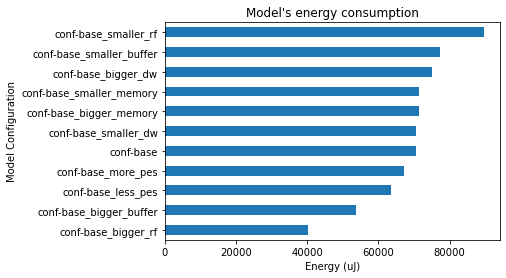

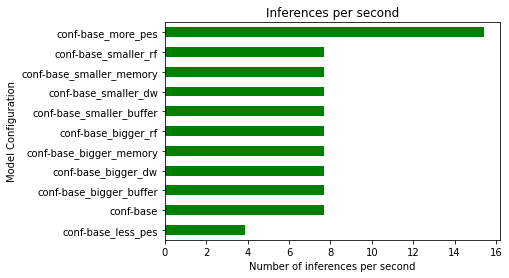

In [3]:
import matplotlib.pyplot as plt

comparison_df = compare_models("workspace/ResNet18/output")

display(comparison_df)

plt.title("Model's energy consumption")
plt.xlabel("Energy (uJ)")
plt.ylabel("Model Configuration")

comparison_df["Energy"].sort_values().plot.barh()

plt.show()

plt.title("Inferences per second")
plt.xlabel("Number of inferences per second")
plt.ylabel("Model Configuration")

comparison_df["Inferences/Second"].sort_values().plot.barh(color="green")

plt.show()

From the above plots, we can see that what really influences energy consumption are the size of the Global and, most of all, the size of the internal Register Files of the PEs. In particular, the bigger they are, the less they consume. This is actually coherent with what we said at the beginning, __i.e. movement is more expensive than computation__: indeed a smaller local buffer/register file implies more data movement.

Regarding the number of inferences per second, it is straightforward to notice how the more PEs imply more inferences per second. No other factor seems to affect throughput. But at the same time, more PEs means more energy consumption, even though the difference in energy are not as huge as the differences in energy due to the size of register files and local buffer.